In [1]:
import os 

import pandas as pd
import numpy as np
import scipy.stats
from sklearn.linear_model import LinearRegression
import sklearn.preprocessing
import sklearn.metrics

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import seaborn as sns

import top2000analysis

In [2]:
FOLDER_OUTPUT = os.path.join('..', 'Output')
FOLDER_DATA = os.path.join('..', 'Data')

Recently, I published a [blog](https://sjoerdcornelissen.com/2021/03/02/the-effect-of-passing-away-on-top-2000-ranking/.) on the effect of passing away on rakings in the Top 2000. In this blog series, I will show how I built all the steps.

I will do so in three parts:
1. Part 1: Reading and understanding the data
1. Part 2: Building and checking a hierarchical Bayesian regresson model
1. Part 3: Using the model for inference and prediction

THIS NOTEBOOK IS STILL UNDER CONSTRUCTION AND WILL BE UPDATED

# Read and inspect the Top 2000 data 
## Scraping the data
First, we scrape all the data from wikipedia. This is done in the `readtop2000` module. It does so in 4 steps:
1. Scrape the full list from https://nl.wikipedia.org/wiki/Lijst_van_Radio_2-Top_2000%27s
1. Split into a data model, which contains 4 tables:

    a. All unique songs
    
    b. All unique artists
    
    c. The ranking of each song in each year
    
    d. The artist(s) who performed each song
1. For each artist, visit their personal wikipedia page and download all data from the infobox

1. Finally, save all the data in the Data folder

Since we only need to do this once, the lines below are commented out

In [3]:
# import readtop2000
# readtop2000.Top2000Downloader().download_and_write()

## Recombining and selecting the data
Now, we wish to get a table on which we can perform the analysis. For this, we combine all data, with one row for each artist for each song, so a song which is a duet occurs twice. 

In [4]:
a = top2000analysis.AnalysisSetCreator()

df_full = a._combine_data(FOLDER_DATA)
print(f"In its history, the Top 2000 has seen {df_full['SongID'].nunique()} unique songs and {df_full['ArtistID'].nunique()} unique artists")

In its history, the Top 2000 has seen 4573 unique songs and 1969 unique artists


For our analysis, we only select the rows of the years in which the artist passed away, and add the information of the year before, so we can compare the number of votes.

We also calculate the percentage of the vote each song received every year based on a model from [Peter Meindertsma](https://www.petermeindertsma.nl/blog/benadering-aantal-stemmen-per-liedje-in-de-top-2000-van-2014/). We end up with the dataframe as shown below, which contains all the information we need to perform the analysis.

In [5]:
df_artist = a.create_artist_set(FOLDER_DATA)
df = a.create_full_feature_set(FOLDER_DATA)

In [6]:
with pd.option_context('display.max_columns', None):
    display(df.sample(5))

,SongID,Year,Rank,Title,YearMade,LinkSong,ArtistID,LinkArtist,Act(s),Afleveringen,Alias,Bedenker,Bekend van,Bekendste werk,Beroep,Beroep(en),Bijnaam,Boek,Budget,Choreografie,Cinematografie,Distributie,Einde,Ensemble(s),Gebaseerd op,Geboorteland,Geboortenaam,Geboorteplaats,Geboren,Genre,Genre(s),Hoofdrollen,Instrument(en),Intromuziek,Invloed(en),Jaren actief,Jaren actief,Laatste voorstelling,Label(s),Land,Land van oorsprong,Manager,Medium,Montage,Muziek,Nationaliteit,Netwerk of omroep,Ook bekend als,Oorsprong,Opbrengst,Opgegroeid te,Overige nominaties,Overleden,Overlijdensplaats,Première,Producent,Pseudoniem,Pseudoniem(en),Regie,Regisseur,Scenario,Speelduur,Start,Stijl,Taal,Teksten,Verwante artiesten,Verwante acts,Volledige naam,Volledige naam,Zangstem,Zender,Geboortedatum,IsOverleden,PassingTooEarly,PctVotesAfterDeathSong,NrArtists,YearsSinceOverlijden,PctVotesBeforeDeathSong,BoostSong,LogBoostSong,PopularityWithinArtist,LogSongPopularityWithinArtist,RecencyWithinArtist,YearsBeforeDeath,JarenGeleden,MultiplePerformers,PctVotesAfterDeathArtist,PctVotesBeforeDeathArtist,LastYearInTop2000,NrsBeforeDeath,Name,IsDutch,AgePassing,JaarTop2000,Overlijdensdatum,EindeStemperiode,DaysToStemperiode,YearsSinceLastHit,LogPopularity,LogPopularityNorm,BoostArtist,LogBoostArtist,SongRelativeBoost,LogRelativeBoost,LogBoost
7222,3076356286897061780,2009,178.0,Shaffy cantate,1965,https://nl.wikipedia.org/wiki/Shaffy_cantate,7551594412476633019,https://nl.wikipedia.org/wiki/Ramses_Shaffy,None,None,None,None,None,None,"Zanger, muzikant, acteur",None,None,None,None,None,None,None,None,None,None,None,None,None,"Neuilly-sur-Seine, 29 augustus 1933",None,Chanson,None,Piano,None,None,1960-2009,None,None,PolyGram,Nederland,None,None,None,None,None,None,None,None,None,None,None,None,"Amsterdam, 1 december 2009",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1933-08-29,True,3.742642,0.001043,1,0.0,0.000160,6.526570,1.875882,0.179035,-0.747062,0.000000,-44.0,-11.0,0,0.023311,0.006249,2005,7,Ramses Shaffy,1,76.257358,2009.0,2009-12-01,2009-12-04,-3,4.0,-2.204206,1.337537,3.730535,1.316552,1.749500,0.806943,1.875882
31121,-4804184633593686765,2006,1203.0,"Marmor, Stein Und Eisen Bricht",1965,https://nl.wikipedia.org/w/index.php?title=Mar...,3182384667423573829,https://nl.wikipedia.org/wiki/Drafi_Deutscher,"Mr. Walkie Talkie, Jack Goldbird, Wir, Masquer...",None,None,None,None,None,"Singer-songwriter, Muziekproducent",None,None,None,None,None,None,None,None,None,None,None,None,None,Berlin-Charlottenburg: 9 mei 1946,None,"Schlager, Rock, Popmuziek",None,None,None,None,1963 - 2006,None,None,"Decca Records, Metronome, Jupiter Records, Han...",Duitsland,None,None,None,None,None,None,None,None,None,None,None,None,Frankfurt am Main: 9 juni 2006,None,None,None,None,None,None,None,None,None,None,None,None,None,Oliver Simon,None,None,Drafi Richard Franz Deutscher,None,None,1946-05-09,True,19.915127,0.000175,1,0.0,0.000173,1.011364,0.011300,1.000000,0.000000,NaN,-41.0,-14.0,0,0.000175,0.000173,1965,1,Drafi Deutscher,0,60.084873,2006.0,2006-06-09,2006-12-01,-175,41.0,-3.761229,-0.219485,1.011364,0.011300,1.000000,0.000000,0.011300
25826,7200327424351326240,2001,581.0,My Sweet Lord,1970,https://nl.wikipedia.org/wiki/My_Sweet_Lord,4097139530644969278,https://nl.wikipedia.org/wiki/George_Harrison,"The Quarrymen, Silver Beetles, The Beat Brothe...",None,"Carl Harrison, L'Angelo Misterioso, Hari Georg...",None,None,None,"Muzikant, Singer-songwriter, Acteur, Muziekpro...",None,None,None,None,None,None,None,None,None,None,None,None,Liverpool,24 februari 1943,None,"Rock, Popmuziek, Psychedelische rock, Experime...",None,"Gitaar, Ukelele, Mondharmonica, Mandoline, Tan...",None,None,1957-2001,None,None,"Parlophone, Capitol Records, Apple Records, Ve...",Verenigd Koninkrijk,None,None,None,None,None,None,None,None,None,None,None,None,29 november 2001,Los Angeles,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None

In [7]:
print(f'The final data contains {len(df)} rows, which means there are {len(df)} songs which were in the Top 2000 the year before the artist passed away.')
print(f'They come from {df["ArtistID"].nunique()} unique artists')

The final data contains 153 rows, which means there are 153 songs which were in the Top 2000 the year before the artist passed away.
They come from 63 unique artists


## Basic data inspection

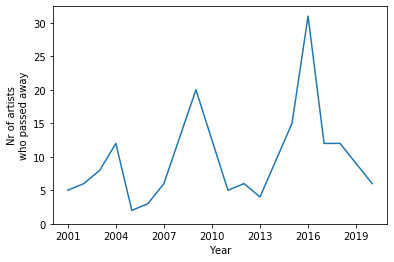

In [8]:
ax = df['Year'].value_counts().sort_index().plot(ylim=(0, None), xlabel='Year', ylabel='Nr of artists\nwho passed away')
ax.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.show()

We see a number of artists passing awayt each year, with a spike in 2016.

Next, let's see what happened to the ranking of each song.

In [42]:
ranks = (df_full
         .pipe(a._rank_features) # Necessary for _song_features
         .pipe(a._song_features) # Calculates the years since overlijden; to find the year before and year of passing away
         .query('-1 <= YearsSinceOverlijden <= 0')
         .loc[lambda df: df.groupby('SongID')['YearsSinceOverlijden'].transform('count') == 2]
         .set_index(['SongID', 'YearsSinceOverlijden'])['Rank']
         .unstack()
        )

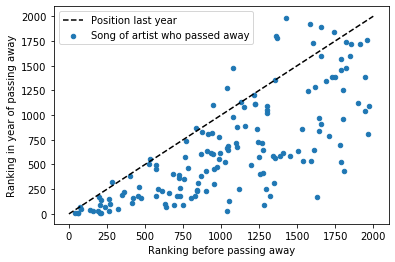

In [46]:
ax = df.merge(ranklastyear.reset_index()).plot(kind='scatter', x='RankLastYear', y='Rank', label='Song of artist who passed away')
ax.plot([0, 2000], [0, 2000], 'k--', label='Position last year')
ax.set_xlabel('Ranking before passing away')
ax.set_ylabel('Ranking in year of passing away')
plt.legend()
plt.show()

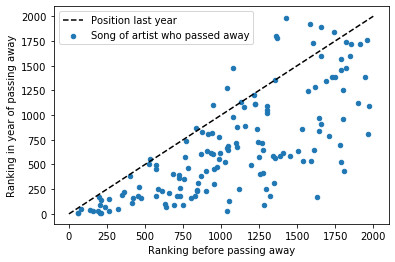

In [43]:
ax = ranks.plot(kind='scatter', x=0, y=-1, label='Song of artist who passed away')
ax.plot([0, 2000], [0, 2000], 'k--', label='Position last year')
ax.set_xlabel('Ranking before passing away')
ax.set_ylabel('Ranking in year of passing away')
plt.legend()
plt.show()

Since most dots are below the dashed line, indeed almost all songs (but notably not all) receive some sort of boost in the year the artist passed away. We also see there are huge differences in the size of the effect: with some songs ranking below 1500 entering the Top 250 a year later, while some Top 500 songs stay right where they are.

For the analysis, the discrete nature of rankings is a problem; the difference between songs ranked 2000 and 1980 is very different from the songs ranked 21st and first. Therefore, we estimate the number of votes through a model developed by [Peter Meindertsma](https://www.petermeindertsma.nl/blog/benadering-aantal-stemmen-per-liedje-in-de-top-2000-van-2014/).
Furthermore, we define a _Boost_  as the ratio between the percentage of votes of the song in the year of the artist passing away and the percentage of the vote of that song in the year before.

In [ ]:
def plot_distribution(series, dist='norm', **kwargs):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    series.plot(kind='kde', ax=axes[0], **kwargs)
    scipy.stats.probplot(series, dist=dist, plot=axes[1])
    plt.show()
    display(series.describe())

In [ ]:
plot_distribution(df['BoostSong'], xlim=(0, None))

We see the average song gets a boost of 2.3x as many votes as the year before, and the median is 1.75x as many votes. Notably, the Boost distrution is not Normal. Therefore, we also inspect the logarithm of the boost:

In [ ]:
plot_distribution(df['LogBoost'])

Still not perfectly normal, but much better. In our further estimation, we will often work with the logarithm, because the regular boost is dominated by a few outliers.

Next, we will also investigate the _artist boost_, defined as the the total number of votes for an artist in the year of his death divided by the total number of votes in the year before, instead of each song individually

In [ ]:
plot_distribution(df_artist['Boost'], xlim=(0, None))

Again, we see the same distribution. Notably, the average _artist_ boost is lower than the average _song_ boost. This can be explained if artists with multiple songs on average see a larger boost. We make the same plot, but now binned for easier interpretation, to show in the blog. 

In [ ]:
def plot_waterfall(data, color=None, buildup=False, **kwargs):
    '''
    Plot a buildup or builddown waterfall chart from data
    This function was adapted from https://pbpython.com/waterfall-chart.html

    Parameters
    ----------
    data: pd.Series to be shown as waterfall
    color: optionally give color as a list for each bar (to highlight some bars)
    buildup: False (default) for builddown, True for buildup

    Returns
    -------
    ax: Axis object
    data: the data, including a "total"-row
    blank: the size of the blank space before each bar
    '''
    if color is None:
        color = ['lightgray'] * len(data)

    blank = data.cumsum().shift(1).fillna(0)
    total = data.sum()
    data.loc['Total'] = total
    blank.loc['Total'] = 0
    color = color + ['gray']
    
    step = blank.reset_index(drop=True).repeat(3).shift(-1)
    step[1::3] = np.nan
    
    if buildup:
        data = data[::-1]
        blank = blank[::-1]
        color = color[::-1]

    ax = data.plot(kind='barh', stacked=True, left=blank, color=color, **kwargs)
    return ax, data, blank

data = pd.cut(df_artist['Boost'], [0, 1, 1.25, 1.5, 2.5, np.inf],
               labels=['No boost',
                       'Up to 25% more votes',
                       'Up to 50% more votes',
                       '1.5 - 2.5 x\nas many votes',
                       'More than 2.5\nx as many votes']).value_counts(normalize=True).sort_index(ascending=False)
data.index = data.index.astype(str)
ax, _, _ = plot_waterfall(data, color=['purple', 'purple', 'purple', 'purple', 'lightgray', 'gray'])
ax.set_ylabel('Effect size')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_frame_on(False)
plt.tight_layout()
plt.gcf().savefig(os.path.join(FOLDER_OUTPUT,'BoostDistribution.png'))

Now, let's check who got the smallest and largest boosts

In [ ]:
display(df_artist.query('Boost < 1')[['Name', 'Boost', 'LogPopularityNorm']].sort_values('Boost'))
display(df_artist.nlargest(10, 'Boost')[['Name', 'Boost', 'LogPopularityNorm']])

# Univariate analysis

To get a first feeling for the data, formulate hypotheses on what affects the size of the boost on three levels:
1. A __base__ effect for every artist
1. An __artist specific__ effect, based on the characteristics of the artist and his/her death - aspects that have to do with how prominent the artist will be in the news after his/her death
1. A __song specific__ effect, for which songs channel the newfound votes.

For each step, the hypotheses are shown in the table below:

<img src="../blogfigures/Hypothesis.png" alt="Hypotheses are formulated for each level, to predict the boost of a song" width="750"/>

In this section, we want to get a first look into the univariate 

Before we dive in, lets check the relative importance of the levels. For this, we look into artist who have multiple songs, and compare the explained variance score for the song boost as explained by the _artist_ boost on the one hand, and the _Relative Song_ boost (the boost of the song divided by the artist boost) on the other hand:

In [ ]:
df_multiple_songs = df.query('NrsBeforeDeath >= 2')
print(f'There are {len(df_multiple_songs)} songs by artists with at least two songs')
artist_variance = sklearn.metrics.explained_variance_score(df_multiple_songs['LogBoost'], np.log(df_multiple_songs['BoostArtist']))
song_variance = sklearn.metrics.explained_variance_score(df_multiple_songs['LogBoost'], df_multiple_songs['LogRelativeBoost'])
print(f'The explained variance of the artist is {artist_variance: .1%}')
print(f'The explained variance of the relative song boost is {song_variance: .1%}')

In [ ]:
ax = sns.violinplot(x='NrsBeforeDeath', y='SongRelativeBoost', data=df)
ax.set_ylim(0,2)

The artist is most important, but we also see there is definetly still a lot of variance within the songs of an artist, which we should try to model.

In [ ]:
def plot_with_trend(df, column, logy=False):
    ycolname = 'LogBoost' if logy else 'Boost'
    preds = LinearRegression().fit(df[[column]], df[ycolname]).predict(df[[column]])
    ax = df.plot(x=column, y=ycolname, kind='scatter', label='Passed away artists', c='grey')
    ax.plot(df[column], preds, 'k', label='Trend')
    return ax

## Artist level

### Artist age
Newsworthiness of the death of an artist depends on the circumstances. Specifically, artists dying young is something that attracts a lot of media attention. This happens a lot in our sample:

In [ ]:
pct_dying_before_80 = df_artist['AgePassing'].lt(80).mean()
print(f'{pct_dying_before_80:.1%} of the artists who passed away were younger than 80')

In [ ]:
ax = plot_with_trend(df_artist, 'AgePassing', logy=True)

We do not see a strong _univariate_ effect, but this may be because of collinearity with other effects

### Jaar
We hypothesize the boost has grown stronger over the years, because of more prevalent news.

In [ ]:
ax = plot_with_trend(df_artist, 'JaarTop2000', logy=True)
ax.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.legend()
plt.tight_layout()
ax.set_frame_on(False)

### Nationality
We hypothesize Dutch voters care more about Dutch artists, out of chauvinism. The effect is hard to detect, since only a small number of Dutch artists passed away

In [ ]:
print(f'{df_artist["IsDutch"].sum()} Dutch artists passed away')

In [ ]:
_ = sns.catplot(x='IsDutch', y='LogBoost', data=df_artist)

### Popularity
When more popular artists die, they get much more news coverage: a relatively unknown artist may get a small article on page 15, while superstars may get entire TV shows devoted to hem. This in turn would result in much more prominent boosts for more popular artists

In [ ]:
ax = plot_with_trend(df_artist, 'PctVotes', logy=True)

This seems to be the case, but the effect between the _logarithm_  of the boost and the percentage of the votes is clearly non-linear, and the trendline is dominated by a few superstars. Let's look into the logarith of the percentage of votes

In [ ]:
plot_with_trend(df_artist, 'LogPopularity', logy=True)

This looks much better: there is a strong, mostly linear relation between the logarith of the boost and the logarithm of the popularity.

### Recency
We hypothesize that the more top of mind a death is, the more of a boost an artist can expect - so more recent deaths during the time of voting should get a larger boost

In [ ]:
ax = plot_with_trend(df_artist.query('DaysToStemperiode > -365'), 'DaysToStemperiode', logy=True)

Indeed, this is the case; however, it is not entirely clear if this is a linear relationship. Lets bucket the observations to see that clearer

In [ ]:
recency_buckets = (pd.cut(df_artist['DaysToStemperiode'].clip(lower=-365), 6, labels=False, retbins=False, right=False)
                  .map({i: v for i, v in enumerate(range(-333, 0, 60))}))

In [ ]:
df_artist.groupby(recency_buckets)['LogBoost'].agg(['mean', 'sem', 'std', 'count'])

In [ ]:
ax = df_artist.groupby(recency_buckets)['LogBoost'].agg(['mean', 'sem', 'std', 'count']).plot(y='mean', yerr='sem')
plt.xlim(-365, 0)
plt.show()

There appears to be little difference out to ~ 150 days, and then the boost grows much stronger.

### Recency of last hit

Finally, there might be an effect whether artists were recently popular

In [ ]:
ax = plot_with_trend(df_artist, 'YearsSinceLastHit', logy=True)

### Correlations

We find that, probably mostly by coincidence, in recent years artists in the Top 2000 have tended to pass away at later ages, which may partly explain why we do not see a strong age effect in a univariate distribution. Furthermore, we see that in recent years more popular artists have tended to pass away, which may spuri

In [ ]:
def plot_correlations(df, figsize=(12, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(df.corr(), cmap='RdBu_r', vmin=-0.8, vmax=0.8, annot=True, fmt='.1%', ax=ax, cbar=False)
    return ax

plot_correlations(df_artist[['AgePassing', 'JaarTop2000', 'DaysToStemperiode', 'LogPopularity', 'IsDutch']], figsize=(6, 6))

## Song

### Solo song
We hypothesize that solo songs get more of a boost than duets

In [ ]:
df.groupby(['NrArtists'])['LogBoost'].agg(['mean', 'std', 'sem', 'count'])

There is only one song that has more than 2 performers (namely, _Laat me/Vivre_ by Alderliefste, Liesbeth List and Ramses Shaffy; the latter two have passed away during the Top 2000), so let's group that together, since the errors are huge.

In [ ]:
display(df.groupby(['MultiplePerformers'])['LogBoost'].agg(['mean', 'std', 'sem', 'count']))
(df.groupby(['MultiplePerformers'])
 ['LogBoost'].agg(['mean', 'std', 'sem', 'count'])
 .plot(y='mean', yerr='sem',
       xlim=(-0.5, 1.5), kind='bar')
)

There are not a lot of duets, but there is a hint they may indeed have a smaller boost

### Popularity within artist oeuvre

In the [literature](https://link.springer.com/article/10.1007/s11002-014-9322-1) there is some work that shows more popular albums get larger boosts.

In [ ]:
ax = plot_with_trend(df, 'PopularityWithinArtist', logy=True)

We do not see that effect very strongly, but again, we are dominated by a few outliers

In [ ]:
ax = plot_with_trend(df, 'LogSongPopularityWithinArtist', logy=True)

In fact, there appears to be a contrary effect. This may be explained, however, by a) our assumptions of the voting distribution and/or b) collinearity with other effects

### Recency within artist

I hypothesize the more recent work may receive more of a boost, since the older work may be somewhat forgotten by now

In [ ]:
ax = plot_with_trend(df.query('NrsBeforeDeath > 2'), 'RecencyWithinArtist', logy=True)

We do not see that effect.